## Data Cleaning and Exploratory Data Analysis/ Customer Data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import seaborn as sns

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep = '\t')
print(df.shape)
df.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# Are there any duplicated data?
if df['ID'].nunique() == df.shape[0]:
    print ('There are no duplicated data in dataset.')
else:
    print('There are duplicated data in dataset.')

There are no duplicated data in dataset.


In [4]:
# This dataset was prepared between 07/2012 and  06/2014, so we can't take the actual year(2023) as relevant for counting the age of clients.
# we need to get relevant age at the point of survey to analyze the customer's behaviour correctly
df = (
      df 
      .assign(Children = lambda df : df['Kidhome'] + df['Teenhome'])
      .assign(Dt_Customer = lambda df : pd.to_datetime(df['Dt_Customer'], format = '%d-%m-%Y', errors = 'coerce'))
      .assign(Age = lambda df : df['Dt_Customer'].dt.year - df['Year_Birth'])
)     

In [5]:
# First and last customer's enrolment
first_enrol = df['Dt_Customer'].min()
last_enrol  = df['Dt_Customer'].max()
duration = (last_enrol - first_enrol).days
print(f'This dataset contains data about {len(df)} customers.')
print(f'First enrollment on : {first_enrol:%Y-%m-%d}')
print(f'Last enrollment on :  {last_enrol:%Y-%m-%d}')
print(f'Duration of the data collection to get the dataset: {duration} days')

This dataset contains data about 2240 customers.
First enrollment on : 2012-07-30
Last enrollment on :  2014-06-29
Duration of the data collection to get the dataset: 699 days


In [6]:
df['Marital_Status'] = df['Marital_Status'].replace({'Together':'In relationship','Widow':'Single',
                                                     'Alone':'Single','Absurd':'Single','YOLO':'Single'})

In [7]:
df['Education'] = df['Education'].replace({'Graduation':'Graduate','PhD': 'Postgraduate',
                                           'Master':'Graduate','2n Cycle':'Undergraduate',
                                           'Basic':'Undergraduate'})

In [8]:
df['Total_spending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

In [9]:
df.drop(columns = ['Kidhome','Teenhome','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
                   'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue','Response'], inplace = True)

In [10]:
df.rename(columns = {'ID':'Customer_ID','MntWines':'Amount_Wines', 'MntFruits':'Amount_Fruits','MntMeatProducts':'Amount_Meat',
                        'MntFishProducts':'Amount_Fish','MntSweetProducts':'Amount_Sweets','MntGoldProds':'Amount_Gold'},inplace = True)

In [11]:
df = df.reindex(columns = ['Customer_ID','Year_Birth','Age','Marital_Status','Children','Education','Income','Dt_Customer','Recency',
                      'Amount_Wines','Amount_Fruits','Amount_Meat','Amount_Fish','Amount_Sweets','Amount_Gold','Total_spending',
                      'NumDealsPurchases','NumCatalogPurchases','NumWebPurchases','NumStorePurchases','NumWebVisitsMonth'])

<AxesSubplot:xlabel='Age'>

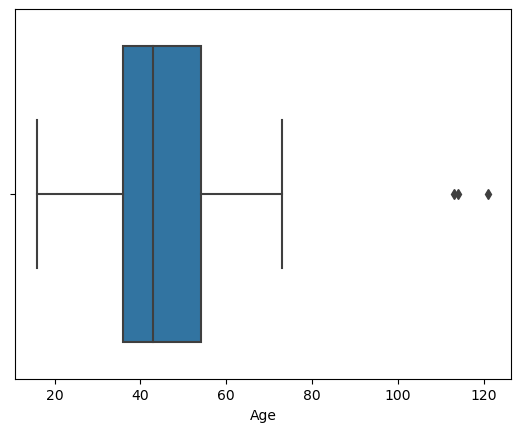

In [12]:
# Detection of outliers in 'Age' column
sns.boxplot(data = df, x = 'Age')

In [13]:
print(np.where(df['Age']>100))

(array([192, 239, 339]),)


In [14]:
# putting median age value istead of outlier's values 
median = df['Age'].median()
df['Age'] = np.where(df['Age'] > 100, median, df['Age'])

<AxesSubplot:xlabel='Income'>

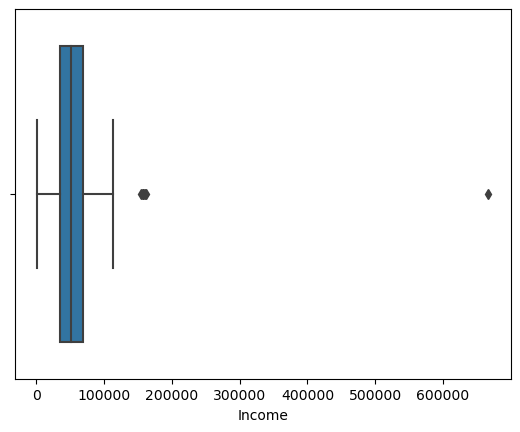

In [15]:
# Detection of outliers in 'Income' column
sns.boxplot(data = df, x = 'Income')

In [16]:
# There are more yearly incomes over 100k and one over 600k
# I will treat income over 200k as an outlier
# Replacing the outlier with a NaN value           ---> later on, converting the NaN value into median income value
df.loc[df['Income'] > 200000, 'Income'] = np.nan

In [17]:
# All missing values in dataset
df_missing_val  = (
                  df
                  .isnull().sum()
                  .to_frame('count_missing_values')
                  .query('count_missing_values > 0')
)
df_missing_val

,count_missing_values
Income,25


In [18]:
# 24 customers were not willing to share their yearly income in that survey + 1 NaN value,an outlier over 600k
# I take the median yearly income based on education level to fill the missing values
df_income = (
             df
            .groupby('Education')
            .agg(median_income = ('Income','median'))
            .astype(int)
)
df_income

,median_income
Education,
Graduate,51533
Postgraduate,55212
Undergraduate,36223


In [19]:
df['Income'] = df.groupby('Education')['Income'].transform(lambda x: x.fillna(x.median()))

## Correlation


In [20]:
corr_df = df.corr()

In [21]:
# All low correlations are replaced with 0
filter_low_correlations = (corr_df > -0.7) & (corr_df < 0.7)
corr_df[filter_low_correlations] = 0

# All correlations equal to 1 are replaced with 0
filter_ideal_correlations = (corr_df == 1.0)
corr_df[filter_ideal_correlations] = 0

<AxesSubplot:>

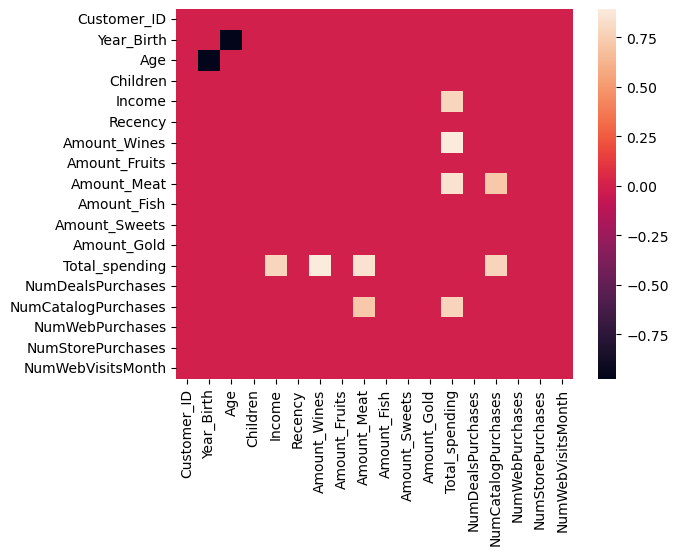

In [22]:
fig = sns.heatmap(corr_df)
fig